# <span style="color:red"> NSL Esercitazione 4 </span>
### <span style="color:pink">  Giacomo Boringhieri 13457A</span>

## <span style="color:blue">  Esercizio 4.1</span>

In meccanica statistica la distribuzione di Maxwell-Boltzmann viene utilizzata per descrivere le valocità dalle particelle in un gas ideale.
tuttavia, gas rarefatti a temperature ordinarie si comportano in modo molto simile a un gas ideale, e la distribuzione di Maxwell-Boltzmann rappresenta un'eccellente approssimazione per tali sistemi. Per un sistema tridimensionale, la formula è:
$$p(v,T) = \left( \frac{m}{2\pi k_B T} \right)^{3/2} 4\pi v^2 e^{-\frac{m v^2}{2 k_B T}}$$
Utilizzando le unità ridotte di Lennard-Jones LJ (Lunghezza: $\sigma$; Energia: $\epsilon$; Massa: la massa, $m$, delle particelle; Temperatura: $\epsilon/k_B$; velocità: $\sqrt{\epsilon/m}$) la forma di semplifica in:
$$p(v^*,T^*) = \frac{1}{(2\pi T^*)^{3/2}} 4\pi (v^*)^2 e^{-\frac{(v^*)^2}{2 T^*}}$$


Ho integrato nel codice `NSL_SIMULATOR` il calcolo della distribuzione $p(v*,T*)$, sfruttando la tecnica del data blocking per ottenere medie per blocco, valori progressivi e incertezze associate alla distribuzione. Si è approssimata la distribuzione costruendo un istogramma normalizzato nell'intervallo $[0, \nu_{max}]$, suddiviso in $30$ bin.
La curva teorica sarà uno strumento utile per analizzare la convergenza e l'accuratezza dei dati prodotti

## <span style="color:blue">  Esercizio 4.2</span>

In questo esercizio ho una simulazione di Dinamica Molecolare con il modello di Lennard-Jones per l'Argon (parameters: $\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) nelle seguenti condizioni:
- gas phase: $\rho^\star = 0.05$, $T^\star \sim  2.0$ (cut-off radius: $r_c = 5.0$)

Ho impostato il sistema iniziale in una configurazione a entropia molto bassa:
- posizione iniziale dellle particelle: cristallo fcc che occupa metà dalla box in ongi direzione
- ditribuzione iniziale delle velocità: $p(v^*,T^*) = \delta(v^* - v_{T^*})$ dove $v_{T^*}$ è connessa a $T^*$. 

Ho effettuato una simulazione con 50 blocchi da 2000 step, come si può osservare la convergenza degli istogrammi verso la distribuzione di MB è molto rapida, ho infatti plottato soli i primi 16 bolcchi.

La simulazione di dinamica molecolare (MD) descrive infatti un sistema ad energia totale costante: l’energia potenziale e quella cinetica oscillano, scambiandosi continuamente, ma la loro somma rimane invariata. Per questo motivo la temperatura del sistema non è perfettamente costante: essa riflette l’energia cinetica istantanea delle particelle, che fluttuano attorno a un valore medio. Durante questo processo di equilibrazione, le particelle abbandonano gradualmente la configurazione iniziale per assumere una disposizione più disordinata, caratteristica di un sistema gassoso. Le loro velocità, inizialmente distribuite in modo non realistico, si riorganizzano progressivamente fino ad avvicinarsi alla distribuzione di Maxwell-Boltzmann, che descrive il comportamento statistico atteso in condizioni di equilibrio termodinamico. In questo modo, la simulazione mostra come, a partire da condizioni arbitrarie, il sistema evolva spontaneamente verso uno stato fisicamente significativo, in cui le proprietà microscopiche delle particelle riflettono le leggi generali della meccanica statistica.

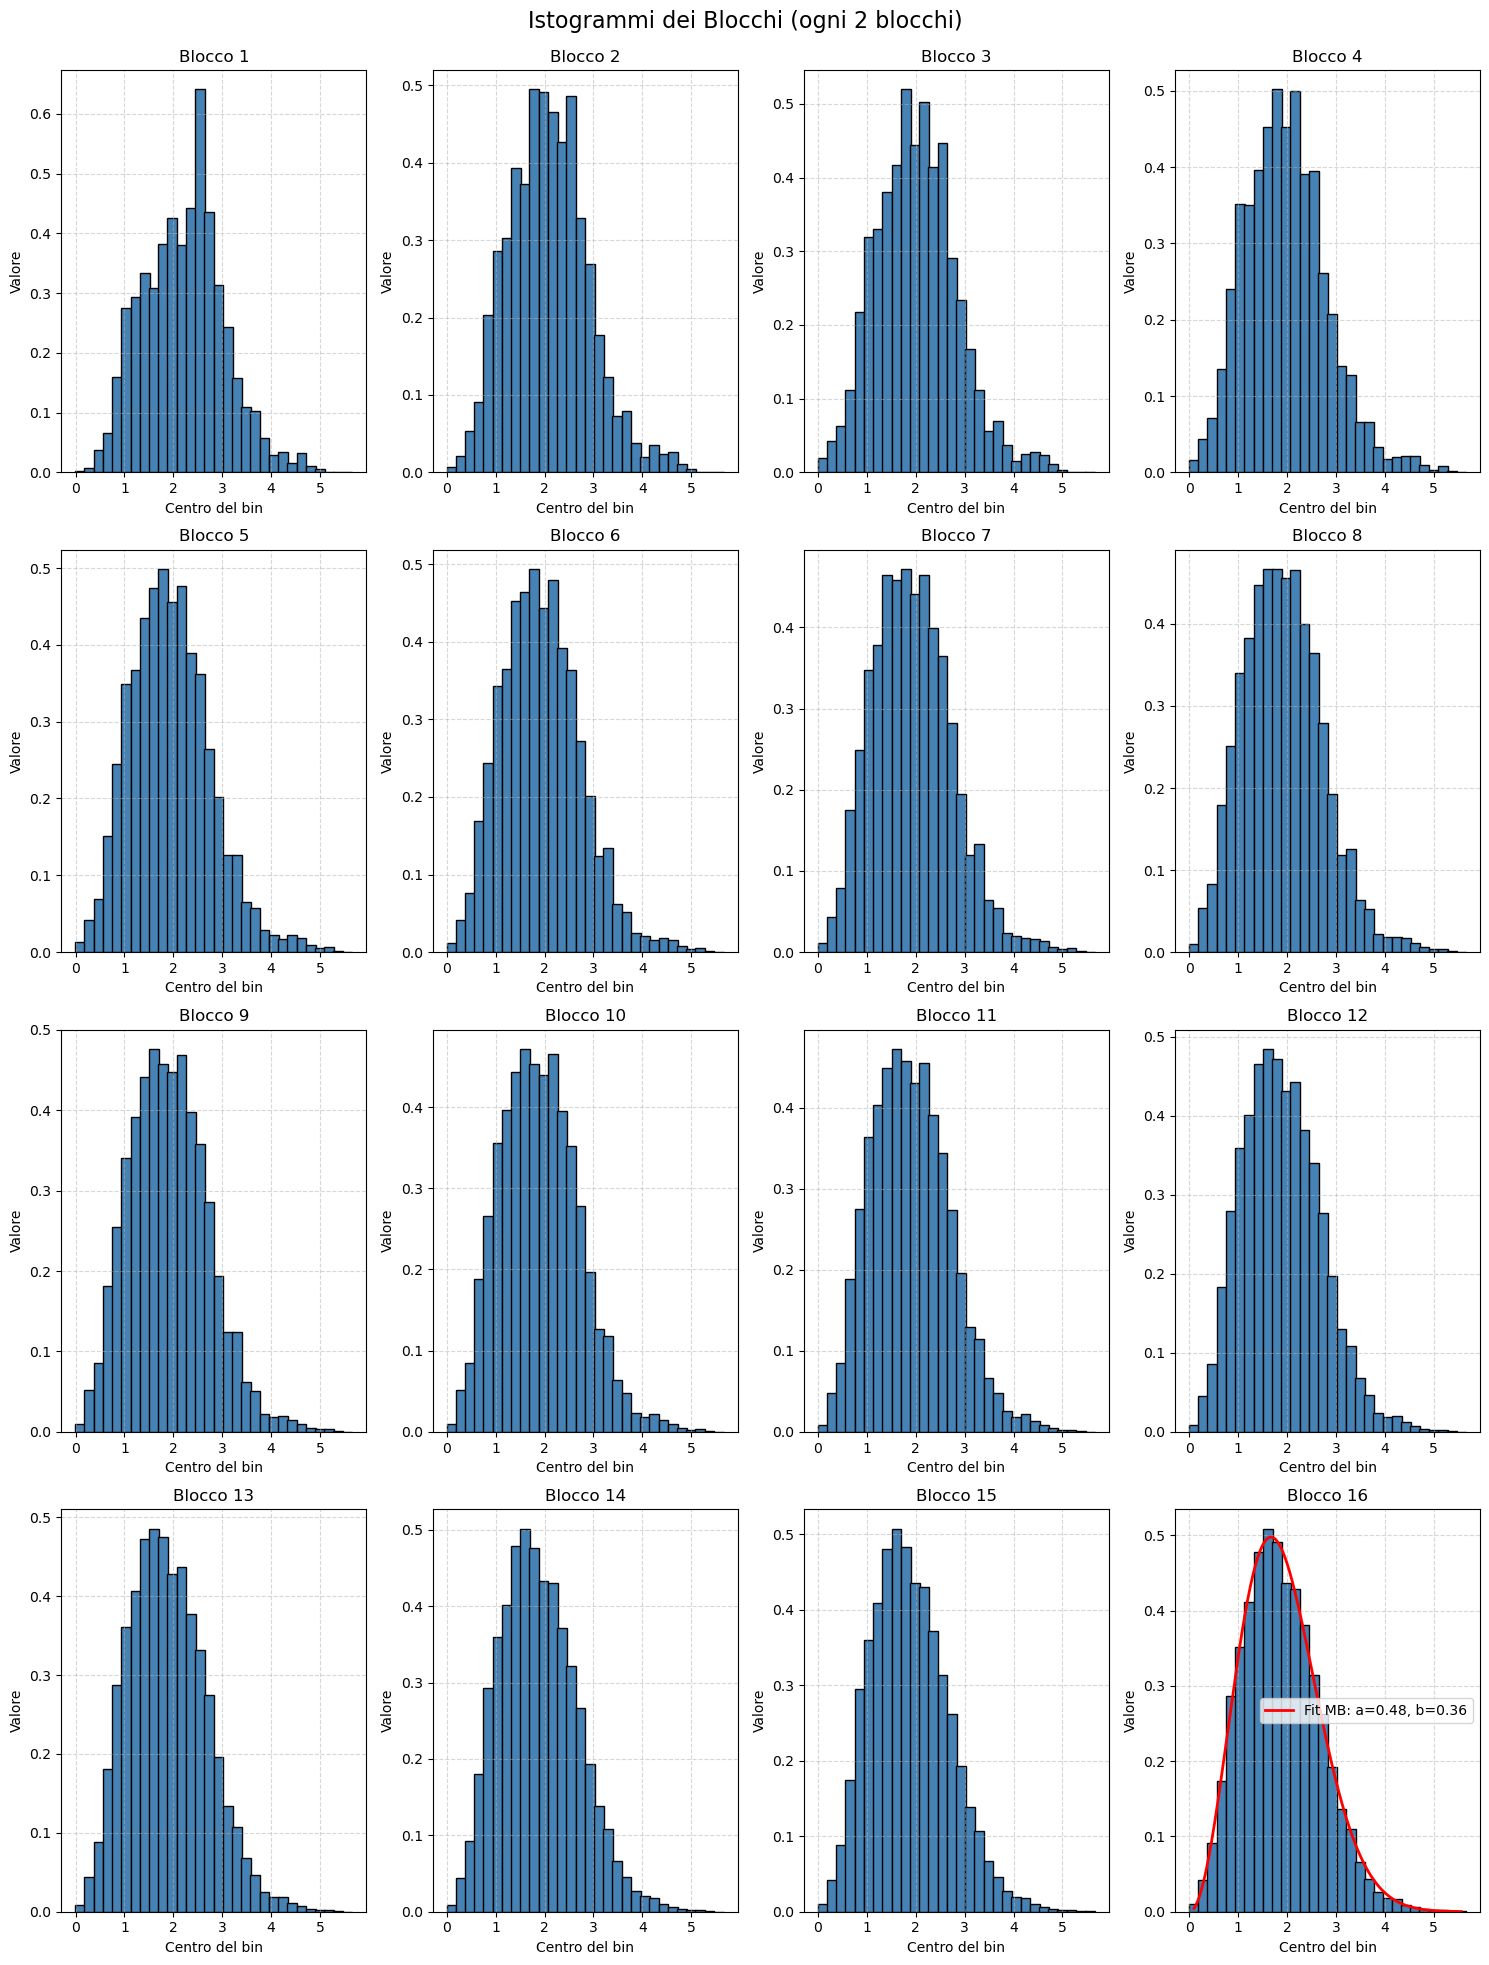

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def leggi_blocchi(filename):
    blocchi = []
    blocco_corrente = []
    with open(filename, 'r') as f:
        for riga in f:
            riga = riga.strip()
            if riga == '' or riga.startswith('#'):
                if blocco_corrente:
                    blocchi.append(np.array(blocco_corrente, dtype=float))
                    blocco_corrente = []
            else:
                blocco_corrente.append(list(map(float, riga.split())))
        if blocco_corrente:
            blocchi.append(np.array(blocco_corrente, dtype=float))
    return blocchi

# Carica i blocchi
blocchi = leggi_blocchi("es2/OUTPUT/pofv.dat")

# Filtra i blocchi validi (con almeno 3 colonne)
blocchi_validi = [blocco for blocco in blocchi if blocco.shape[1] >= 3]
blocchi_da_plottare = blocchi_validi[::1][:16]  # Prendi un blocco ogni 2, max 16

# Calcola il layout della griglia
n_grafici = len(blocchi_da_plottare)
n_cols = 4  # Numero di colonne nella griglia
n_rows = (n_grafici + n_cols - 1) // n_cols  # Calcola il numero di righe necessario

# Crea la figura con subplot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
fig.suptitle('Istogrammi dei Blocchi (ogni 2 blocchi)', fontsize=16)

# Appiattisci l'array di assi per facilitare l'iterazione
axes = axes.flatten()

# Plotta ogni blocco in un subplot diverso
for i, (blocco, ax) in enumerate(zip(blocchi_da_plottare, axes)):
    x = blocco[:, 0]  # centro del bin
    y = blocco[:, 2]  # valore 

    ax.bar(x, y, width=0.2, color='steelblue', edgecolor='black')
    ax.set_title(f"Blocco {i+1}")
    ax.set_xlabel("Centro del bin")
    ax.set_ylabel("Valore")
    ax.grid(True, linestyle='--', alpha=0.5)

# Fit di Maxwell-Boltzmann sull’ultimo blocco
def maxwell_boltzmann(v, a, b):
    return a * v**2 * np.exp(-b * v**2)

x_last = blocchi_da_plottare[-1][:, 0]
y_last = blocchi_da_plottare[-1][:, 2]

# Fit con curve_fit
popt, _ = curve_fit(maxwell_boltzmann, x_last, y_last, p0=[1, 1])

# Disegna il fit sull’ultimo subplot
x_fit = np.linspace(min(x_last), max(x_last), 300)
y_fit = maxwell_boltzmann(x_fit, *popt)

ax_last = axes[len(blocchi_da_plottare) - 1]
ax_last.plot(x_fit, y_fit, 'r-', lw=2, label=f'Fit MB: a={popt[0]:.2f}, b={popt[1]:.2f}')
ax_last.legend()

# Nascondi gli assi vuoti se il numero di grafici non riempie completamente la griglia
for j in range(len(blocchi_da_plottare), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Spazio per il titolo principale
plt.show()

## <span style="color:blue">  Esercizio 4.3</span>

Si potrebbe ipotizzare che, per riportare il sistema alla configurazione iniziale a bassa entropia, sia sufficiente invertire il verso del tempo nella simulazione. Per verificare questa idea è stata condotta una nuova simulazione utilizzando come condizioni iniziali le ultime due configurazioni generate durante l’equilibrazione, salvate nei file config e conf-1. La temperatura è stata fissata al valore raggiunto al termine del processo di equilibrazione. Infine, le velocità delle particelle non sono state mantenute uguali a quelle precedenti, ma riassegnate casualmente in accordo a una distribuzione statistica, invece che concentrate in una distribuzione delta.

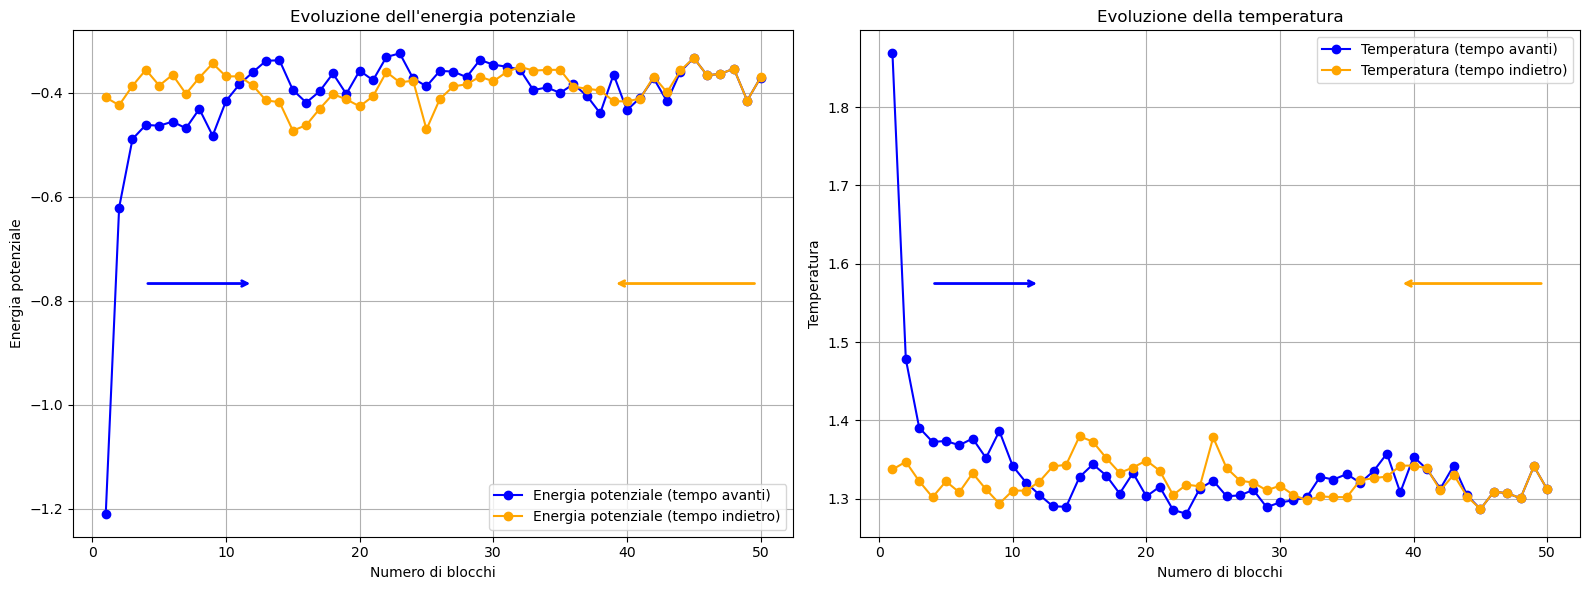

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def read_data(filename):
    with open(filename) as f:
        lines = f.read().strip().split('\n')[1:]  # Skip header
    x, y = [], []
    for line in lines:
        parts = line.split()
        if len(parts) >= 2:
            x.append(float(parts[0]))
            y.append(float(parts[1]))
    return np.array(x), np.array(y)

files = [
    "es2/OUTPUT/potential_energy.dat",
    "es3/OUTPUT/potential_energy.dat",
    "es2/OUTPUT/temperature.dat",
    "es3/OUTPUT/temperature.dat"
]

labels = [
    "Energia potenziale (tempo avanti)",
    "Energia potenziale (tempo indietro)",
    "Temperatura (tempo avanti)",
    "Temperatura (tempo indietro)"
]

colors = ['blue', 'orange', 'blue', 'orange']
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot potential energy (primo grafico a sinistra)
for i in range(2):
    x, y = read_data(files[i])
    if i == 1:  # Inverti SOLO il secondo (arancio)
        x = x[::-1]

    axs[0].plot(x, y, label=labels[i], marker='o', color=colors[i])

axs[0].set_title("Evoluzione dell'energia potenziale")
axs[0].set_xlabel("Numero di blocchi")
axs[0].set_ylabel("Energia potenziale")
axs[0].legend()
axs[0].grid(True)

# Plot temperature (secondo grafico a destra)
for i in range(2, 4):
    x, y = read_data(files[i])
    if i == 3:  # Inverti SOLO il quarto (arancio)
        x = x[::-1]

    axs[1].plot(x, y, label=labels[i], marker='o', color=colors[i])

axs[1].set_title("Evoluzione della temperatura")
axs[1].set_xlabel("Numero di blocchi")
axs[1].set_ylabel("Temperatura")
axs[1].legend()
axs[1].grid(True)

# Aggiunta delle frecce esplicative
# Blu (tempo avanti, da sinistra a destra)
axs[0].annotate('', xy=(0.25, 0.50), xycoords='axes fraction',
                xytext=(0.10, 0.50), arrowprops=dict(arrowstyle='->', color='blue', lw=2))

axs[1].annotate('', xy=(0.25, 0.50), xycoords='axes fraction',
                xytext=(0.10, 0.50), arrowprops=dict(arrowstyle='->', color='blue', lw=2))

# Arancio (tempo indietro, da destra a sinistra)
axs[0].annotate('', xy=(0.75, 0.50), xycoords='axes fraction',
                xytext=(0.95, 0.50), arrowprops=dict(arrowstyle='->', color='orange', lw=2))

axs[1].annotate('', xy=(0.75, 0.50), xycoords='axes fraction',
                xytext=(0.95, 0.50), arrowprops=dict(arrowstyle='->', color='orange', lw=2))

fig.tight_layout()
plt.show()

La simulazione mette in evidenza come, una volta che il sistema ha raggiunto uno stato caratterizzato da entropia più elevata, esso non ritorni spontaneamente alla configurazione iniziale ordinata. Questo risultato è coerente con il secondo principio della termodinamica, secondo cui un sistema isolato non può evolvere naturalmente verso condizioni di entropia minore. Allo stesso tempo, l’andamento osservato non è dovuto unicamente a motivi termodinamici, ma riflette anche aspetti legati alla natura numerica della simulazione.

In particolare, l’integrazione delle equazioni del moto tramite l’algoritmo di Verlet, pur essendo formalmente reversibile, introduce inevitabili approssimazioni dovute agli errori di arrotondamento. Tali imprecisioni, per quanto minuscole a ogni singolo passo, si accumulano progressivamente e si amplificano con il tempo di simulazione. Di conseguenza, nelle fasi iniziali l’evoluzione calcolata segue fedelmente la traiettoria teorica, mentre col passare dei passi di integrazione emerge una crescente deviazione dal percorso inverso ideale. Questo comportamento non va interpretato come un limite dell’algoritmo, bensì come una manifestazione numerica dell’irreversibilità intrinseca: l’informazione microscopica del sistema tende a disperdersi nel rumore numerico, riproducendo in modo realistico la perdita di reversibilità che caratterizza i processi fisici reali.
